In [8]:
from pyreadr import read_r
import pickle

from arboreto.algo import grnboost2
from arboreto.utils import load_tf_names
from pyscenic.utils import modules_from_adjacencies
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell, derive_auc_threshold

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase

import pandas as pd
import os
import seaborn as sns
import matplotlib as plt

import logging

### Prelimanary

Load count matrix and TFs names. \
\
Note: 
<ul>
    <li>count matrix generated by R script import_data.R, from file data/dpn.vnc.domain.labelled.rds </li>
    <li>TF names are copied from https://github.com/aertslab/pySCENIC/blob/master/resources/allTFs_dmel.txt (29.3.2023)</li>
<ul>

In [9]:
ex_matrix = pd.read_csv("../data/expression_mat.csv", index_col=0)  # load count matrix 
tf_names = load_tf_names("../data/allTFs_dmel.txt") # Derive list of Transcription Factors(TF) for Drosophila

In [5]:
ex_matrix.shape

(3855, 9751)

In [96]:
ex_matrix

,a,abd-A,Abd-B,Abl,abo,ac,acj6,Acph-1,Act5C,Act42A,...,lncRNA:CR43716,lncRNA:CR44997,asRNA:CR45151,lncRNA:CR45310,lncRNA:CR45425,asRNA:CR45822,asRNA:CR45891,lncRNA:CR45961,lncRNA:CR46032,lncRNA:CR46119
TP1_AACTCAGGTAAATACG,0.0,0.000000,0.0,0.0,0.466624,0.000000,0.0,0.0,2.764117,1.750383,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP1_TCACGAATCTATCGCC,0.0,1.053208,0.0,0.0,0.000000,0.483831,0.0,0.0,2.879282,1.053208,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP1_TACGGTACAATAGAGT,0.0,0.813928,0.0,0.0,0.000000,0.000000,0.0,0.0,2.458085,1.059571,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP1_CAACTAGAGAGACGAA,0.0,0.000000,0.0,0.0,0.000000,0.888313,0.0,0.0,2.728522,2.006819,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP1_GCGCCAAAGTCGATAA,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,3.294131,1.989672,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TP2.2_AACACGTCATTCACTT,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,2.463590,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP2.2_TCTTTCCGTACCGTTA,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,3.506908,2.466545,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP2.2_GATTCAGCACACGCTG,0.0,2.470005,0.0,0.0,0.000000,1.858055,0.0,0.0,3.119940,1.858055,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP2.2_TGAGCATGTGATGTCT,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.854410,2.466052,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0


Load ranking databases (for motif enrichment)  --> https://resources.aertslab.org/cistarget/ (https://resources.aertslab.org/cistarget/databases/drosophila_melanogaster/dm6/flybase_r6.02/mc8nr/gene_based/)

In [10]:
db_fnames = "../data/dm6-5kb-upstream-full-tx-11species.mc8nr.genes_vs_motifs.rankings.feather"
dbs = [RankingDatabase(fname=db_fnames, name=os.path.splitext(os.path.basename(db_fnames))[0])]
dbs


[FeatherRankingDatabase(name="dm6-5kb-upstream-full-tx-11species.mc8nr.genes_vs_motifs.rankings")]

Motif annotation file: https://resources.aertslab.org/cistarget/motif2tf/ (v8 matches mc8nr db)

In [11]:
motif_annotation_file = "../data/motifs-v8-nr.flybase-m0.001-o0.0.tbl"

#### Run Pipeline
line by line to get familiar with the outputs, and time the commands. 

In [12]:
# sample matrix:
ex_matrix_sub = ex_matrix.iloc[1:100,1:500]
# run first step
adjacencies = grnboost2(ex_matrix_sub, tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph
4 partitions
computing dask graph
shutting down client and local cluster
finished


In [13]:
adjacencies

,TF,target,importance
53,Brd,E(spl)m5-HLH,3.687917e+01
495,sna,sca,2.138833e+01
465,sala,sca,1.828094e+01
333,E(spl)m5-HLH,rst,1.794850e+01
172,FER,Gart,1.668760e+01
...,...,...,...
218,hay,Arl1,3.657316e-16
248,ImpL2,nkd,2.747921e-16
22,AnxB9,ase,2.530264e-16
132,ec,LanA,1.584127e-16


In [13]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix_sub)) 
modules


2023-05-24 16:19:35,838 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-05-24 16:19:35,845 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2023-05-24 16:19:36,020 - pyscenic.utils - INFO - Creating modules.


[Regulon(name='Regulon for Act42A', gene2weight=frozendict.frozendict({'Myb': 2.664187281542204, 'PpV': 2.561811392754385, 'E(spl)malpha-BFM': 1.7614403432953472, 'Fib': 1.6983326603222546, 'fj': 1.1304519542720888, 'dsh': 1.0776446541279998, 'RpII215': 1.0689838571363333, 'aop': 1.0654097202111699, 'pip': 0.9450596160096948, 'slo': 0.8900084310266004, 'sti': 0.8555316848187445, 'Gal': 0.8387063788739605, 'Rm62': 0.8347514844659637, 'dup': 0.7409953238550502, 'smo': 0.6488140448695945, 'mam': 0.6084285479201709, 'Eip75B': 0.5824174271996706, 'crp': 0.48932273351991756, 'DNApol-zeta': 0.46998499854984416, 'ImpL2': 0.46629611114616115, 'wek': 0.4593991770211542, 'chic': 0.44564643756744604, 'chif': 0.44063277203269713, 'Dr': 0.4203533070264177, 'Kr': 0.3988886916538496, 'mod': 0.39662665422518834, 'numb': 0.3893010103603637, 'Act42A': 1.0}), gene2occurrence=frozendict.frozendict({}), transcription_factor='Act42A', context=frozenset({'weight>75.0%', 'activating'}), score=0.0, nes=0.0, ort

In [21]:
modules[1]


Regulon(name='Regulon for Act5C', gene2weight=frozendict.frozendict({'chif': 1.862244838145099, 'Sap-r': 1.7134937978265417, 'inv': 1.648536505862241, 'Mybbp1A': 1.6254871975386755, 'CycA': 1.621240140658466, 'hth': 1.495037858642255, 'Poxm': 1.4406668015333692, 'kkv': 1.385262928056424, 'Hsp67Ba': 1.2257543091651377, 'numb': 1.1888846149543304, 'ifc': 1.1723181001823542, 'RpII215': 1.1571919566646451, 'exd': 0.9099037081364286, 'Lar': 0.8962733511521475, 'sens': 0.7597792426852297, 'okr': 0.6839832913971687, 'l(1)10Bb': 0.6826278894700637, 'Gart': 0.6787329433409397, 'Gli': 0.6493283879687307, 'Hsp27': 0.6424547826875752, 'PpV': 0.5823025276632724, 'cort': 0.5621610033854862, 'bic': 0.5572906209563305, 'shi': 0.5473106732062405, 'Ras64B': 0.5342821512515061, 'hfw': 0.5315908599017927, 'sesB': 0.5233149967354643, 'peb': 0.5034281489411072, 'mago': 0.4732398930554864, 'bsh': 0.4707982703934201, 'E(bx)': 0.44031481432773234, 'ninaA': 0.41890955227139764, 'E(z)': 0.4051692219289528, 'wek'

In [3]:
help(prune2df)

Help on function prune2df in module pyscenic.prune:

prune2df(rnkdbs: Sequence[Type[ctxcore.rnkdb.RankingDatabase]], modules: Sequence[ctxcore.genesig.Regulon], motif_annotations_fname: str, rank_threshold: int = 1500, auc_threshold: float = 0.05, nes_threshold=3.0, motif_similarity_fdr: float = 0.001, orthologuous_identity_threshold: float = 0.0, weighted_recovery=False, client_or_address='dask_multiprocessing', num_workers=None, module_chunksize=100, filter_for_annotation=True) -> pandas.core.frame.DataFrame
    Calculate all regulons for a given sequence of ranking databases and a sequence of co-expression modules.
    The number of regulons derived from the supplied modules is usually much lower. In addition, the targets of the
    retained modules is reduced to only these ones for which a cis-regulatory footprint is present.
    
    :param rnkdbs: The sequence of databases.
    :param modules: The sequence of modules.
    :param motif_annotations_fname: The name of the file that 

More on RcisTarget: https://www.bioconductor.org/packages/release/bioc/vignettes/RcisTarget/inst/doc/RcisTarget_MainTutorial.html#What_is_RcisTarget

In [25]:
df = prune2df(dbs, modules, motif_annotations_fname=motif_annotation_file) # Prune modules for targets with cis regulatory footprints (RcisTarget)
df

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2023-05-24 16:41:00,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Pka-C1 could be mapped to dm6-5kb-upstream-full-tx-11species.mc8nr.genes_vs_motifs.rankings. Skipping this module.


Enrichment  \
                                                                           AUC   
TF               MotifID                                                         
aop              cisbp__M6213                                         0.232019   
                 hocomoco__ERG_MOUSE.H10MO.A                          0.235996   
                 transfac_pro__M00339                                 0.237819   
hth              cisbp__M1137                                         0.232473   
l(1)sc           tfdimers__MD00222                                    0.174787   
pnt              cisbp__M0701                                         0.246256   
                 transfac_pro__M07417                                 0.243356   
slp1             transfac_pro__M07286                                 0.122970   
Abd-B            taipale_tf_pairs__FOXO1_HOXB13_RWMAACASYMRTWAAA...   0.182804   
aop              taipale_tf_pairs__ETV7_NNGGAAGTGCTTCCNN_HT           0.153314   
hth              cisbp__M1137                                         0.169620   
opa              flyfactorsurvey__opa_SOLEXA_FBgn0003002              0.152730   
pnt              cisbp__M0701                                         0.175914   
slp1             transfac_pro__M07286                                 0.129665   
                 transfac_pro__M01216                                 0.126571   
crp              transfac_public__M00176                              0.165591   
                 transfac_pro__M00927                                 0.177746   
                 cisbp__M2947                                         0.169827   
Abd-B            taipale_tf_pairs__FOXO1_HOXB13_RWMAACASYMRTWAAA...   0.190116   
E(spl)mgamma-HLH cisbp__M2361                                         0.118019   
                 jaspar__MA0568.1                                     0.118084   
                 swissregulon__sacCer__PHO4                           0.109310   
Myb              transfac_pro__M08890                                 0.101641   
aop              taipale_tf_pairs__ETV7_NNGGAAGTGCTTCCNN_HT           0.162896   
hth              cisbp__M1137                                         0.150980   
l(1)sc           hocomoco__ASCL2_HUMAN.H10MO.D                        0.147078   
opa              flyfactorsurvey__opa_SOLEXA_FBgn0003002              0.174041   
pnt              cisbp__M0701                                         0.180192   
                 swissregulon__hs__STAT5_A_B_.p2                      0.184617   
sd               transfac_pro__M01102                                 0.124599   
wor              cisbp__M5178                                         0.140108   

                                                                               \
                                                                          NES   
TF               MotifID                                                        
aop              cisbp__M6213                                        3.073060   
                 hocomoco__ERG_MOUSE.H10MO.A                         3.159408   
                 transfac_pro__M00339                                3.198984   
hth              cisbp__M1137                                        3.404815   
l(1)sc           tfdimers__MD00222                                   3.271700   
pnt              cisbp__M0701                                        3.188644   
                 transfac_pro__M07417                                3.126516   
slp1             transfac_pro__M07286                                4.219214   
Abd-B            taipale_tf_pairs__FOXO1_HOXB13_RWMAACASYMRTWAAA...  3.032657   
aop              taipale_tf_pairs__ETV7_NNGGAAGTGCTTCCNN_HT          3.338959   
hth              cisbp__M1137                                        3.709358   
opa              flyfactorsurvey__opa_SOLEXA_FBgn0003002             3.002516   
pnt              cisbp__M0701                                   

In [36]:
len(pd.unique([x[0] for x in df.index]))

12

In [37]:
regulons = df2regulons(df) # convert data frame to rergulons

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [10]:
auc_mtx = aucell(ex_matrix_sub, regulons, num_workers=1)
auc_mtx

100%|██████████| 9/9 [00:01<00:00,  4.96it/s]


Regulon,D(+),Jra(+),RpII215(+),abd-A(+),aop(+),l(1)sc(+),opa(+),pnt(+),run(+)
Cell,,,,,,,,,
TP1_AAACCTGAGTAACCCT,0.0,0.0,0.00000,0.0,0.0,0.012345,0.004238,0.0,0.0
TP1_AAAGATGTCTCCCTGA,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0
TP1_AAAGCAATCTTCCTTC,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0
TP1_AAATGCCGTGGGTCAA,0.0,0.0,0.00000,0.0,0.0,0.000367,0.000336,0.0,0.0
TP1_AACTGGTGTCAACATC,0.0,0.0,0.00000,0.0,0.0,0.033732,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
TP1_TTCGAAGGTTAAGGGC,0.0,0.0,0.00365,0.0,0.0,0.000000,0.000000,0.0,0.0
TP1_TTCGGTCAGTTGAGTA,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0
TP1_TTCTACAAGTACTTGC,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0


Visualization of aucell table

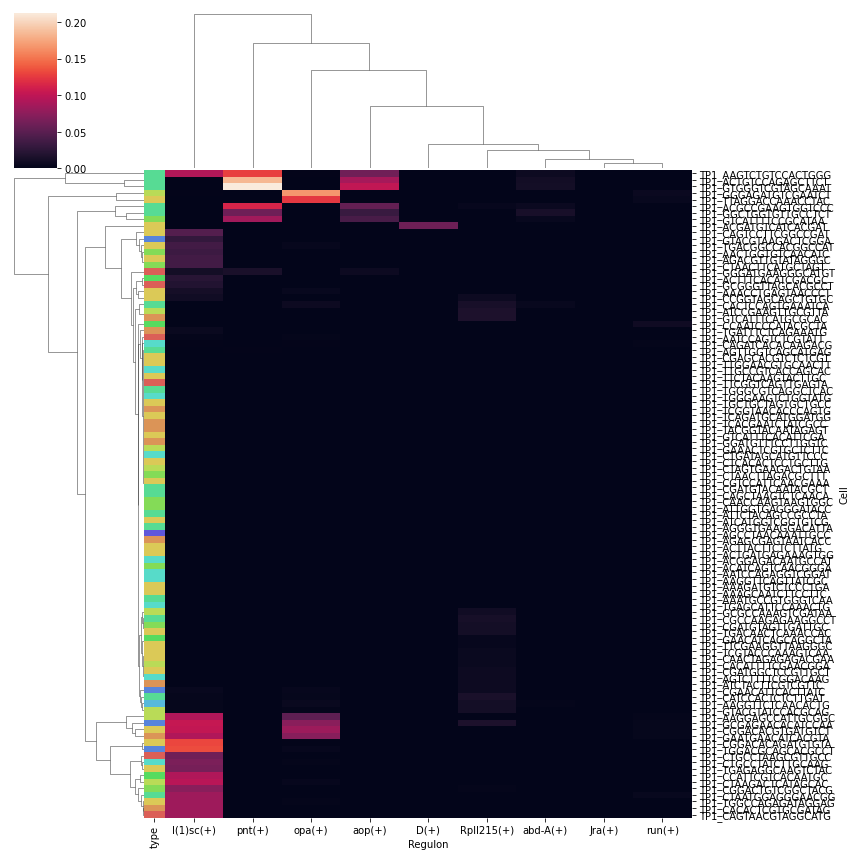

In [80]:

types_df = pd.read_csv("../data/cell_type.csv", index_col=0) 

sns.color_palette("hls", 15)
lut = dict(zip(types_df.type.unique(), sns.color_palette("hls", 15)))
cell_colors = types_df.type.map(lut)
row_colors = auc_mtx.merge(cell_colors, how='left', left_index=True, right_index=True).type
ax= sns.clustermap(auc_mtx, figsize=(12,12,),yticklabels=True, xticklabels=True, row_colors=row_colors)



In [11]:
from pyscenic.aucell import create_rankings

create_rankings(ex_matrix)  # ranking of gene expression in each cell 



,Rpn8,CG15744,CG8155,Aatf,Ero1L,CG11404,NaCP60E,Cdk1,ATPsyndelta,Lsd-1,sca,lncRNA:CR43870,shi,CG14573,lncRNA:CR45473,Nap1,CG10984,Rbfox1,lncRNA:CR44953,CG9886,Nadsyn,Ubx,mars,nrv2,snoRNA:Or-CD4,CG3655,CG1218,pcm,CG16926,pgc,sano,CG7638,Gr8a,MED21,CG1663,Ptp69D,Hip14,MME1,CG2147,dbr,...,GstD10,RpS29,IKKepsilon,Fbxl7,CarT,CG14100,CG7639,dpr17,comt,CG12674,Kaz1-ORFB,Hipk,DNAlig4,Grip91,CG14204,Mst36Fa,bib,LpR1,stai,lncRNA:CR43356,lwr,mrn,asRNA:CR45999,CG11470,CG15282,DNApol-alpha73,asRNA:CR45281,Tsen2,CG9804,cutlet,Ance-3,Bacc,CG15098,CG3770,NO66,SCCRO3,Pgant4,Npc2h,Hen1,CG12391
TP1_AACTCAGGTAAATACG,1271,2641,2642,2643,1272,2644,2645,216,181,2646,142,2647,2648,2649,2650,406,2651,2652,2653,2654,2655,1273,2656,1274,2657,1275,2658,2659,2660,2661,2662,2663,2664,754,2665,2666,1276,2667,2668,2669,...,9718,74,9719,9720,9721,9722,9723,9724,9725,9726,9727,2639,9728,9729,9730,9731,1269,9732,9733,9734,136,1270,9735,9736,9737,2640,9738,9739,9740,9741,9742,54,9743,9744,9745,9746,9747,9748,9749,9750
TP1_TCACGAATCTATCGCC,2568,2569,2570,2571,2572,2573,2574,332,400,2575,401,2576,2577,2578,2579,1280,2580,750,2581,2582,2583,1281,751,1282,2584,2585,2586,2587,2588,2589,2590,1283,2591,1284,2592,2593,2594,2595,2596,2597,...,9717,69,9718,9719,9720,9721,9722,9723,9724,9725,9726,1278,9727,9728,9729,9730,9731,9732,9733,9734,149,2567,9735,9736,9737,9738,9739,9740,9741,9742,9743,65,9744,9745,1279,9746,9747,9748,9749,9750
TP1_TACGGTACAATAGAGT,559,2507,2508,2509,2510,2511,2512,278,279,2513,335,2514,2515,2516,2517,788,2518,1282,2519,2520,2521,1283,789,1284,2522,1285,2523,2524,2525,2526,2527,1286,2528,790,2529,1287,1288,791,2530,2531,...,9719,54,2504,9720,9721,9722,9723,9724,2505,9725,9726,2506,9727,9728,9729,9730,9731,9732,9733,9734,100,9735,9736,9737,9738,9739,9740,9741,1280,9742,9743,59,9744,9745,1281,9746,9747,9748,9749,9750
TP1_CAACTAGAGAGACGAA,2421,2422,2423,2424,2425,2426,2427,345,176,2428,1202,2429,2430,2431,2432,706,2433,1203,2434,2435,2436,1204,2437,2438,2439,2440,2441,2442,2443,2444,2445,707,2446,708,2447,1205,2448,2449,2450,2451,...,9718,50,9719,9720,9721,9722,9723,9724,9725,9726,9727,2417,9728,2418,9729,9730,2419,9731,9732,9733,243,9734,9735,9736,9737,9738,9739,9740,2420,9741,9742,41,9743,9744,9745,9746,9747,9748,9749,9750
TP1_GCGCCAAAGTCGATAA,2359,2360,1113,2361,2362,2363,2364,356,357,2365,1114,2366,671,2367,2368,1115,2369,2370,2371,2372,2373,2374,2375,1116,2376,1117,2377,2378,2379,2380,2381,2382,2383,1118,2384,2385,2386,2387,2388,2389,...,9718,28,9719,9720,9721,9722,9723,9724,9725,9726,9727,1112,9728,9729,9730,9731,355,9732,9733,9734,157,9735,9736,9737,9738,2357,9739,9740,9741,9742,9743,64,9744,9745,9746,2358,9747,9748,9749,9750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TP2.2_AACACGTCATTCACTT,776,777,778,779,780,781,782,271,272,783,273,784,785,786,787,274,788,275,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,276,804,805,806,807,808,809,...,9715,28,9716,9717,9718,9719,9720,9721,775,9722,9723,9724,9725,9726,9727,9728,9729,9730,9731,9732,270,9733,9734,9735,9736,9737,9738,9739,9740,9741,9742,1,9743,9744,9745,9746,9747,9748,9749,9750
TP2.2_TCTTTCCGTACCGTTA,783,784,785,786,787,788,789,790,791,792,265,793,794,795,796,266,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,...,9718,20,9719,9720,9721,779,9722,9723,9724,9725,9726,9727,9728,9729,9730,9731,780,9732,9733,9734,139,9735,9736,9737,9738,9739,9740,9741,9742,9743,9744,2,9745,9746,781,9747,9748,9749,9750,782
TP2.2_GATTCAGCACACGCTG,712,713,714,715,716,717,718,223,224,719,720,721,722,723,724,225,226,725,726,727,728,227,228,229,729,730,230,731,732,733,734,735,736,737,738,739,740,741,742,743,...,9715,56,710,9716,9717,9718,9719,9720,9721,9722,9723,9724,9725,9726,9727,

AUCEll matrix + cell type

In [143]:
cell_type = pd.read_csv("../data/cell_type.csv", index_col=0)
withtype = pd.merge(auc_mtx[0:10], cell_type, left_index=True, right_index=True)

withtype  # last column is type, add later to heatmap # TODO 

,E(spl)m7-HLH(+),Hrb98DE(+),Hsf(+),Jra(+),Myb(+),RpII215(+),aop(+),ase(+),cg(+),en(+),esg(+),fkh(+),hth(+),kn(+),mor(+),opa(+),pnt(+),slou(+),wor(+),type
TP1_AAACCTGAGTAACCCT,0.008319,0.004071,0.000363,0.0,0.0,0.013272,0.000000,0.015149,0.0,0.000957,0.000000,0.0,0.059390,0.0,0.025444,0.0,0.000000,0.0,0.014446,7-4
TP1_AAAGATGTCTCCCTGA,0.024957,0.011955,0.000000,0.0,0.0,0.003209,0.000000,0.045447,0.0,0.000000,0.000000,0.0,0.002373,0.0,0.005865,0.0,0.000000,0.0,0.000000,7-4
TP1_AAAGCAATCTTCCTTC,0.015252,0.004269,0.000000,0.0,0.0,0.011552,0.000000,0.027773,0.0,0.000000,0.000000,0.0,0.010837,0.0,0.024949,0.0,0.000000,0.0,0.000000,7-4
TP1_AAATGCCGTGGGTCAA,0.027730,0.007685,0.000000,0.0,0.0,0.008343,0.000000,0.050497,0.0,0.000000,0.000000,0.0,0.007508,0.0,0.017801,0.0,0.000000,0.0,0.007223,MG
TP1_AACTGGTGTCAACATC,0.027730,0.000000,0.000000,0.0,0.0,0.009626,0.000000,0.050497,0.0,0.000000,0.000000,0.0,0.019641,0.0,0.011717,0.0,0.003806,0.0,0.000000,1-2
TP1_AAGGAGCCATTGCGGC,0.027730,0.000854,0.000000,0.0,0.0,0.008605,0.000000,0.050497,0.0,0.000000,0.000862,0.0,0.026082,0.0,0.019251,0.0,0.000843,0.0,0.009198,1-1
TP1_AAGGTTCAGTTATCGC,0.004160,0.005977,0.000000,0.0,0.0,0.011469,0.000000,0.007575,0.0,0.000000,0.000000,0.0,0.015722,0.0,0.024546,0.0,0.000000,0.0,0.000000,5-3
TP1_AAGGTTCTCAACACTG,0.026344,0.005349,0.000000,0.0,0.0,0.005776,0.004314,0.047972,0.0,0.000000,0.000000,0.0,0.015605,0.0,0.009234,0.0,0.000000,0.0,0.028891,3-5
TP1_AAGTCTGTCCACTGGG,0.075261,0.007091,0.001090,0.0,0.0,0.010910,0.000000,0.035348,0.0,0.002870,0.000862,0.0,0.056566,0.0,0.024342,0.0,0.051217,0.0,0.025280,MG
TP1_AATCCAGAGGTCGGAT,0.000000,0.004914,0.000000,0.0,0.0,0.011070,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.019501,0.0,0.027017,0.0,0.000000,0.0,0.000000,5-3


Binarize

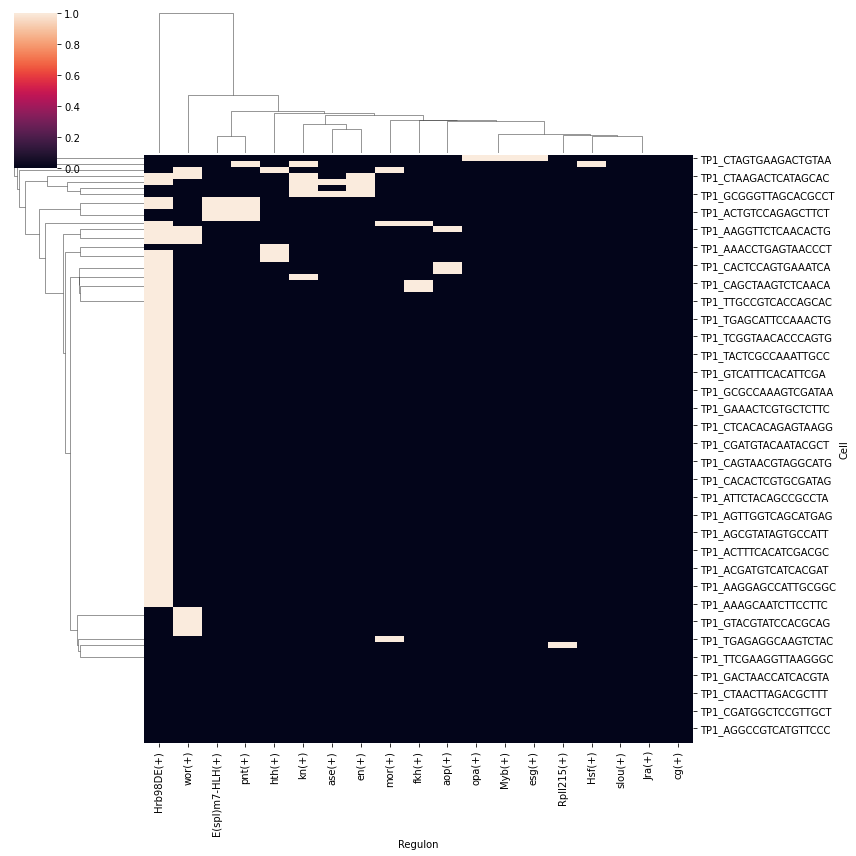

In [50]:
from pyscenic.binarization import binarize

binary_aucell = binarize(auc_mtx)
sns.clustermap(binary_aucell[0], figsize=(12,12))
# binary_aucell[1]  # thresholds per regulon

# can visualize each regulon's distribution + this threshold 

Binarization

Threshold is automatically found. \
if distribution is unimodal => threshold is mean+2sd \
else => fit two component Gaussian Mixture model on the AUC distribution using an Expectation-Maximization algorithm to identify the peaks in the distribution \
(https://github.com/aertslab/pySCENIC/blob/master/src/pyscenic/binarization.py)


Draw distributions of AUC values for a regulon across cells. Functions taken from https://pyscenic.readthedocs.io/en/stable/faq.html

In [92]:
import matplotlib.pyplot as plt

def plot_binarization(auc_mtx: pd.DataFrame, regulon_name: str, threshold: float, ax=None) -> None:
    """
    Plot the "binarization" process for the given regulon.

    :param auc_mtx: The dataframe with the AUC values for all cells and regulons (n_cells x n_regulons).
    :param regulon_name: The name of the regulon.
    :param bins: The number of bins to use in the AUC histogram.
    :param threshold: The threshold to use for binarization.
    """
    if ax is None:
        ax=plt.gca()
   
    auc_mtx[regulon_name].hist(ax=ax, bins='auto')  # originally bins are chosen to be 200

    ylim = ax.get_ylim()
    ax.plot([threshold]*2, ylim, 'r:')
    ax.set_ylim(ylim)
    ax.set_xlabel('AUC')
    ax.set_ylabel('# cells')
    ax.set_title(regulon_name)

    


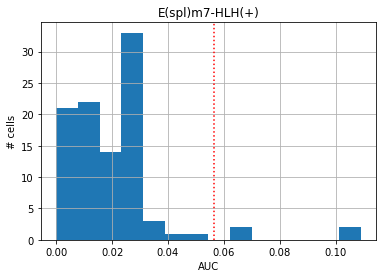

In [93]:
if not os.path.exists("results/figs"):
    os.mkdir("results/figs")

for regulon in list(auc_mtx.columns.values):
    plot_binarization(auc_mtx=auc_mtx, regulon_name=regulon, threshold=binary_aucell[1][regulon])
    plt.savefig(f"results/figs/{regulon}.pdf")
    # break

In [28]:
if not os.path.exists("results/"):
    os.mkdir("results")

preparing dask client
parsing input
creating dask graph
4 partitions
computing dask graph
shutting down client and local cluster



2023-05-11 11:13:18,991 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-05-11 11:13:18,999 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].


finished



2023-05-11 11:13:19,209 - pyscenic.utils - INFO - Creating modules.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2023-05-11 11:14:20,166 - pyscenic.transform - WARNING - Less than 80% of the genes in pim could be mapped to dm6-5kb-upstream-full-tx-11species.mc8nr.genes_vs_motifs.rankings. Skipping this module.


Create regulons from a dataframe of enriched features.
Additional columns saved: []


100%|██████████| 13/13 [00:00<00:00, 937.34it/s]


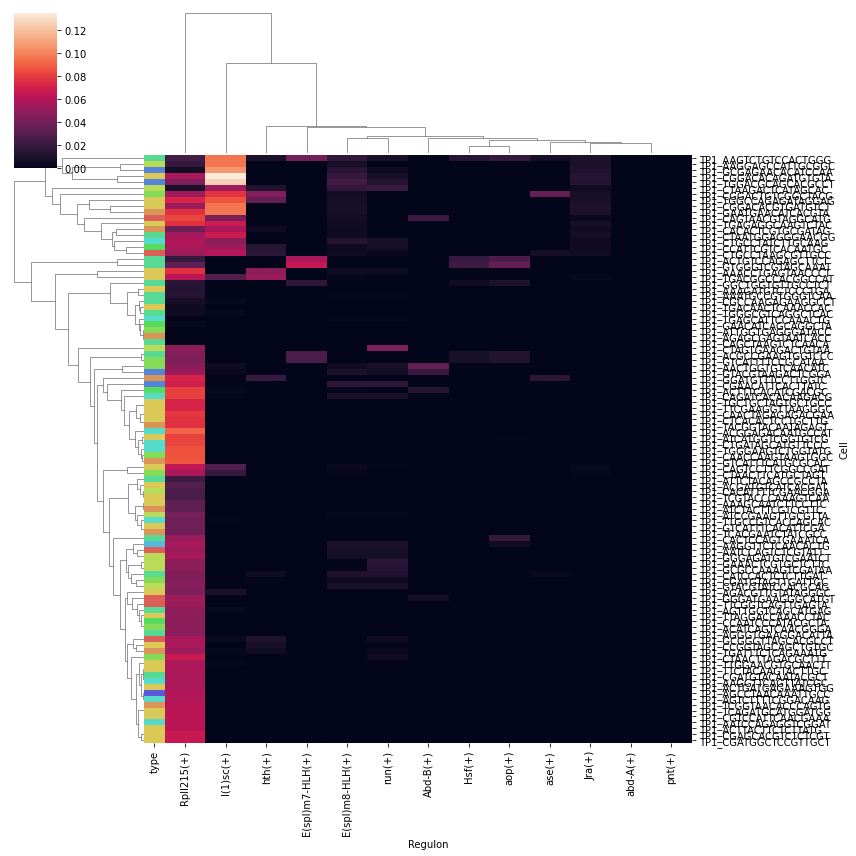

In [83]:
n = 1  # TODO: decide on n based on computational resources 
all_results = [None] * n
for i in range(0, n):  # TODO: replace N, replace ex_matrix_sub with ex_matrix
    run_num = i+1
    if not os.path.exists(f"results/run_{run_num}"): os.mkdir(f"results/run_{i+1}")

    """ phase 1 - GRN inference, generation of co-expression modules """
    adjacencies = grnboost2(ex_matrix_sub, tf_names, verbose=True) # adjacencies table of tf, target and importance weight
    modules = list(modules_from_adjacencies(adjacencies, ex_matrix_sub)) # module generation - candidate regulons from TF-target gene interactions 
    # save to files:
    adjacencies.to_csv(f"results/run_{run_num}/adjacencies.csv", index=False, sep='\t')
    with open(f"results/run_{run_num}/modules.pkl", 'wb') as f:
        pickle.dump(modules, f)

    """ phase 2+3 - Regulon prediction """
    df = prune2df(dbs, modules, motif_annotations_fname=motif_annotation_file) # Prune modules for targets with cis regulatory footprints (RcisTarget)
    regulons = df2regulons(df) # convert data frame to rergulons
    # save to files:
    df.to_csv(f"results/run_{run_num}/motifs.csv")
    with open(f"results/run_{run_num}/regulons.pkl", 'wb') as f:
        pickle.dump(regulons, f)

    """ phase 4 - cellular enrichment """
    auc_mtx = aucell(ex_matrix_sub, regulons, num_workers=1)  # Calculate enrichment of gene signatures for single cells. # TODO: change num_workers
    auc_mtx.to_csv(f"results/run_{run_num}/AUCell_mat.csv")
    # auc_mtx.to_pickle(f"results/results_{i+1}.pkl")# pickle results to results/ folder for later analysis
    # AUCell returns A dataframe with the AUCs (n_cells x n_modules).

    types_df = pd.read_csv("../data/cell_type.csv", index_col=0) 

    # heatmap
    lut = dict(zip(types_df.type.unique(), sns.color_palette("hls", len(types_df.type.unique()))))
    cell_colors = types_df.type.map(lut)
    row_colors = auc_mtx.merge(cell_colors, how='left', left_index=True, right_index=True).type
    ax= sns.clustermap(auc_mtx, figsize=(12,12,),yticklabels=True, xticklabels=True, row_colors=row_colors)
    ax.savefig(f"results/run_{run_num}/AUCell_heatmap.png")



    

In [12]:
    
directory = "results/"
count_per_cell = {}
for filename in os.listdir(directory):  # iterate over all pickle files
     file = os.path.join(directory, filename)
     if not file.endswith(".pkl"):
         continue
     res_df = pd.read_pickle(file)
     #res_df.to_csv(f'{os.path.splitext(file)[0]}.csv')
     
     

RSS 

In [27]:

from pyscenic.rss import regulon_specificity_scores

types_df = pd.read_csv("../data/cell_type.csv", index_col=0) 
types_serise = types_df[types_df.index.isin(auc_mtx.index)].squeeze()
regulon_specificity_scores(auc_mtx, types_serise)



,D(+),Jra(+),RpII215(+),abd-A(+),aop(+),l(1)sc(+),opa(+),pnt(+),run(+)
7-1,0.167445,NaN,0.258809,0.167445,0.167445,0.267428,0.224376,0.167445,0.252779
7-4,0.167445,NaN,0.210984,0.233313,0.228250,0.305997,0.240791,0.229331,0.215668
1-1,0.167445,NaN,0.262907,0.293419,0.234718,0.212991,0.193588,0.234916,0.167445
5-6,0.167445,NaN,0.253189,0.167445,0.167445,0.191525,0.180677,0.167445,0.167445
1-2,0.167445,NaN,0.242586,0.167445,0.167445,0.289893,0.215827,0.167445,0.199178
5-2,0.167445,NaN,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.275542
MG,0.242176,NaN,0.282668,0.278727,0.296368,0.195516,0.182092,0.296742,0.193111
5-3,0.167445,NaN,0.187005,0.167445,0.167445,0.184675,0.234872,0.167445,0.222841
3-5,0.167445,NaN,0.240773,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445
3-2,0.167445,NaN,0.178970,0.167445,0.167445,0.351520,0.249559,0.167445,0.221819
